## Purpose of this notebook :
In this notebook, we are trying to understand the points we couldn't understand clearly. And also we will deep dive into Pyrocko library. 

### Imports:

Here you will need sim_fractal file to run this notebook. This will be in the same directory, so you can direclty run this notebook. That file contains green function solutions which will be needed to determine faults movement.

In [1]:
import os.path
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates  as pdt
from scipy.interpolate import griddata
from pyrocko import gf
import sim_fractal as frct

## Let's start:

In the below cell, we define **store_id**. 

This store_id is used by pyrocko to download necessary file. In our case **store_id** is  **'gfs_ismetpasa'** since we are going to validate our results using real ismetpaşa data.

**Caution**: This function will download the file only if 'gfs_ismetpasa' is not in the same directory. In our case, we have provided the data for you, so you don't need to download the data. So, although you will run the below cell, it will not download the data.

In [2]:
# Download a Greens Functions store
store_id = 'gfs_ismetpasa' 
if not os.path.exists(store_id):
    gf.ws.download_gf_store(site='kinherd', store_id=store_id)

site =  dictionary for urls
* 'localhost': 'http://localhost:8080',
*  'kinherd': 'http://kinherd.org:8080'

In [3]:
# Setup the LocalEngine and point it to the fomosto store you just downloaded.
# *store_superdirs* is a list of directories where to look for GF Stores.
engine = gf.LocalEngine(store_superdirs=['.'])

### Pyrocko Local Engine:
* Offline synthetic seismogram calculator.


Again, we are defining some constant. Here, slip corresponds to slip amount of three different layers. Each slip value is in mm.


**Caution:** All of those constants are defined for one year period. In case you want to determine slip amounts for a smaller interval you should divide the slip value with 365.25 and  multiply with lenght of time interval in terms of day. 

$$ \text{slip for specific interval} = \frac{\text{slip  value}}{365.25}* \text{time interval}$$

In [4]:
km = 1e3       # for convenience
yr = 365.25    # year length in day
slip = [0.022, 0.015, 0.005] #slip values in mm
print(slip)

[0.022, 0.015, 0.005]


Here, we are creating temporal table, which gives information about our time flow.

Here, 
* Ndate,   how many image will be produced
* TempRsl, Temporal resolution, how long it takes for satellite to come back, in terms of day, 
* maxPB,   Perpendicular Baseline, the perpendicular distance between two passing of satellite from the same location.

**Caution**: Although we know our model accepts images in 9 batches, here we produce 10 batches. This is because the first image produced will be empty. 

In [5]:
Ndate   = 10 
TempRsl = 72 
maxPB   = 250

TempTbl = np.linspace(0, Ndate-1, Ndate) * TempRsl
PerpBsl = np.random.randint(-maxPB, maxPB,size=Ndate)

In [6]:
TempTbl

array([  0.,  72., 144., 216., 288., 360., 432., 504., 576., 648.])

As you see we have created a temporal table with 72 day interval.

Below, we are giving the inital time for the first image. Then using temporal table, we get the date for other passings of the satellite.

* PrmDt, data of first image
* PrmNum, PrmDt in terms of day
* ifgsNum, dates of interferogram shots, in terms of day
* ifgsDtNum, dates of interferogram shots, in terms of date


In [7]:
Prm = 0
PrmDt = '2018-05-12'

TempTbl   = np.subtract(TempTbl,TempTbl[Prm])
PrmNum    = pdt.datestr2num(PrmDt) 
ifgsNum   = np.add(TempTbl,PrmNum)
ifgsDtNum = pdt.num2date(ifgsNum)
ifgsDt = []

for i in range(len(TempTbl)):
	ifgDt = str(ifgsDtNum[i].year)+'-'+str(ifgsDtNum[i].month)+'-'+str(ifgsDtNum[i].day)
	ifgsDt.append(ifgDt)

PerpBsl[Prm] = 0

In [8]:
# PrmDt in terms of day
PrmNum 

17663.0

In [9]:
# dates of interferogram shots, in terms of day
ifgsNum

array([17663., 17735., 17807., 17879., 17951., 18023., 18095., 18167.,
       18239., 18311.])

In [10]:
# dates of interferogram shots, in terms of date
ifgsDtNum

[datetime.datetime(2018, 5, 12, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2018, 7, 23, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2018, 10, 3, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2018, 12, 14, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 2, 24, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 5, 7, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 7, 18, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 9, 28, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 12, 9, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 2, 19, 0, 0, tzinfo=datetime.timezone.utc)]

In some faults, we see creeps which last for some time and then stop and start moving again. 
Here we are calculating the displacement (in mm) for each creeping pathes and then outputs the sum of all the displacements. 


Here,
* step, time between two creep 
* N, length of episodic creep events in day
* crpSlip, slip amount
* X, array for interferogram days
* Y, show the amount of displacement

In [11]:
###   Calculate Episodic Creep events 
step = 60
N = 5 
crpSlip  = slip[2]/N   
crpStart = np.arange(2*N,int(np.max(ifgsNum))-int(np.min(ifgsNum))-3, step)
X =  np.arange(1,int(np.max(ifgsNum))-int(np.min(ifgsNum)))
Y = np.zeros(len(X), np.float32)  

for i in crpStart:
	Y[i-N:i+N] = np.logical_and(X[i-N:i+N]>=i-int(N/2),X[i-N:i+N]<=i+int(N/2)-1)
	Y[i-N:i+N] = Y[i-N:i+N] * np.bartlett((i+N)-(i-N))*crpSlip


In [12]:
#amount of slip
crpSlip

0.001

In [13]:
crpStart

array([ 10,  70, 130, 190, 250, 310, 370, 430, 490, 550, 610])


### start of demonstration 
Here I will make you a litle demonstration of what happens inside that for loop:

In [14]:
#choose one i from crpStart array, here I choose i as 70
i = 70

now lets look at what happens inside the for loop:

In [15]:
np.logical_and(X[i-N:i+N]>=i-int(N/2),X[i-N:i+N]<=i+int(N/2)-1)
# np.logical_and(X[65:75]>=68,X[65:75]<=71)

array([False, False,  True,  True,  True,  True, False, False, False,
       False])

This produces an array with boolean arguments. Here we are dividing X into 2N wide chunks and look at the values. If those values are equal or higher then a specific threshold value then np.logical_and return True, otherwise False. I will print the X values for you so that you can convince yourself

In [16]:
X[65:75]

array([66, 67, 68, 69, 70, 71, 72, 73, 74, 75])

In [17]:
Y[i-N:i+N] = Y[i-N:i+N] * np.bartlett((i+N)-(i-N))*crpSlip
# Y[65:75] = Y[65:75] * np.bartlett((75)-(65)) * crpSlip

Here, we are creating values for Y, which has index True, with the barlett function and crpSlip, which is the amount of creep. 

The Bartlett window is very similar to a triangular window, except that the end points are at zero. It is often used in signal processing for tapering a signal, without generating too much ripple in the frequency domain. The parameter we have gave denotes the number of points in the output window. The output of this function is the triangular window, with the maximum value normalized to one with the first and last samples equal to zero.

In [18]:
Y[65:75]

array([0.0000000e+00, 0.0000000e+00, 1.9753087e-07, 4.4444445e-07,
       7.9012347e-07, 7.9012347e-07, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

### end of demonstration

Here we are just defining coordinate system.

For example, in the code below, our pixel will cover an area of 20 km-20km East-West, and 20km-20 km North-South

In [19]:
###  Geographic (Ellipsoidal) Coordinate System 
E = [-20*km, 20*km] 
N = [-20*km, 20*km]

grdSize      = 1*km  #pixel size
Egrid, Ngrid = np.mgrid[E[0]:E[1]:grdSize, N[0]:N[1]:grdSize]
Esize, Nsize = Egrid.shape

In the below, you will find details to define satellite object. We initialize the satellite target and set the line of sight vectors direction. 

* look, angle between the LOS and the vertical, the difference between the first and second index must be at least 20 degrees.
* heading, angle between the azimuth and the North (anti-clock), here it is defined for 3 satellite, plus and minus corresponds to ascending and descending motion of satellite.
* lookA, look angle converted into radian



In [20]:
look    = [33., 54]
heading = [-166, -90, -14, 14, 90, 166] # +90 ekle sentinel olması için 
                                        
###  look angle is converted to Radian
lookA = np.tile(np.linspace(np.deg2rad(look[0]), np.deg2rad(look[1]), Esize), Nsize)  # vertical LOS from horizontal

Now, we are going to calculate position of satellites. 

### Pyrocko Satellite:  

First of all, satellite is a static target class in pyrocko. 
* Pyrocko-GF Targets are data structures holding observer properties to tell the framework what we want to model, e.g. whether we want to model a waveform or spectrum at a specific receiver site or displacement values at a set of locations. 
* Each target has properties (location, depth, physical quantity) and essentially is associated to a GF store, used for modelling. The target also defines the method used to interpolate the discrete, gridded GF components
* Measurement quantity type, for now only displacement issupported.

The SatelliteTarget defines the locations of displacement measurements and the direction of the measurement, which is the so-called line-of-sight of the radar. It is a static target.
* A computation request for a spatial multi-location target of static/geodetic quantities measured from a satellite instrument. The line of sight angles are provided and projecting post-processing is applied.

Parameters:
* theta, numpy.ndarray,  Horizontal angle towards satellite’s line of sight in radians.
    * Important 0 is east and $\frac{\pi}{2}$ is north.
* phi numpy.ndarray, Phi is look vector elevation angle towards satellite from horizon in radians. 
* Returns: Target
* Return type: list

In [21]:
STLT=[] 
for i in range(len(heading)):
    phi = np.empty(Esize*Nsize)    # horizontal LOS from E in anti-clokwise rotation
    phi.fill(np.deg2rad(heading[i]))
    satellite_target = gf.SatelliteTarget(north_shifts=Ngrid, east_shifts=Egrid, tsnapshot=24. * 3600.,  # one day
                                    interpolation='nearest_neighbor', phi=phi,theta=lookA,store_id=store_id)
    STLT.append(satellite_target)

### start of demonstartion:
As it did in the previous cell lets define a list;


In [22]:
STLT_ =[] 

In [23]:
i_ = 2
phi_ = np.empty(Esize*Nsize)
phi_

array([0.00000000e+000, 1.02271589e-321, 0.00000000e+000, ...,
       2.20077938e-314, 5.50883195e-321, 2.20077930e-314])

In [24]:
heading[i_]

-14

In [25]:
phi_.fill(np.deg2rad(heading[i_])) # dereceden radyana 
phi_

array([-0.2443461, -0.2443461, -0.2443461, ..., -0.2443461, -0.2443461,
       -0.2443461])

In [26]:
satellite_target_ = gf.SatelliteTarget(north_shifts=Ngrid, east_shifts=Egrid, tsnapshot=24. * 3600.,  # one day
                                    interpolation='nearest_neighbor', phi=phi,theta=lookA,store_id=store_id)
satellite_target_

In [27]:
#Attributes of satellite target
dir(satellite_target_)

['D',
 'T',
 '_MultiLocation__T',
 '_SatelliteTarget__T',
 '_StaticTarget__T',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__doc_template__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_coords5',
 '_los_factors',
 'base_key',
 'coords5',
 'distance_to',
 'dummy_for',
 'dummy_for_description',
 'dump',
 'dump_xml',
 'east_shifts',
 'elevation',
 'get_corner_coords',
 'get_latlon',
 'get_los_factors',
 'get_targets',
 'interpolation',
 'lats',
 'load',
 'load_xml',
 'lons',
 'ncoords',
 'north_shifts',
 'ntargets',
 'phi',
 'post_process',
 'quantity',
 'regularize',
 'store_id',
 'theta',
 'tsnapshot',
 'validate']

In [28]:
del STLT_, i_, phi_, satellite_target_

### end of demonstration

Here we are defining some properties of fault.
* L[0] -> lenght of inersiesmic part // L[1] -> length of creeping patches,
    * L in general define lenght of creeping patches
* Wdth, width of fault
* Dpth, distance of fault from the ground
* strk, strike, the angle between the North and fault
* dp, dip angle, angle between the fault and the normal to the ground
* rk, rake, angle between the horizon of fault plane and the motion

In [29]:
L = np.multiply([50, 5], km) 
Wdth = np.multiply([100., 5.], km); 
Dpth = [Wdth[0]/2+10*km, Wdth[1]/2+0.5*km]
strk=80.; dp=89.; rk=160.; Nshift = 5; crpMax = slip[1]; epsCrpId = [3,6];

CRP = np.zeros((Nshift*2-1), np.float32)
CRP[0] = crpMax
shift = np.zeros((Nshift*2-1,2), np.float32)
n = 1
for i in range(1, len(shift),2):
	step = n*L[1]
	CRP[i] = crpMax - (n*(crpMax/Nshift))
	CRP[i+1] = crpMax - (n*(crpMax/Nshift))
	shift[i,:] = np.multiply(step,[np.cos(np.deg2rad(90 - strk)), np.sin(np.deg2rad(90 - strk))])
	shift[i+1,:] = np.multiply(step*-1,[np.cos(np.deg2rad(90 - strk)), np.sin(np.deg2rad(90 - strk))])
	n += 1


### start of demonstration:

In [30]:
L_ = np.multiply([50, 5], km) 
Wdth_ = np.multiply([100., 5.], km)
Dpth_ = [Wdth_[0]/2+10*km, Wdth_[1]/2+0.5*km]
L_

array([50000.,  5000.])

In [31]:
CRP_ = np.zeros((Nshift*2-1), np.float32)
CRP_[0] = crpMax
CRP_

array([0.015, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
      dtype=float32)

In [32]:
shift_ = np.zeros((Nshift*2-1,2), np.float32)
shift_

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [33]:
n, i_ = 1, 3
step_ = n*L_[1]
CRP_[i_] = crpMax - (n*(crpMax/Nshift))
CRP_[i_+1] = crpMax - (n*(crpMax/Nshift))
CRP_

array([0.015, 0.   , 0.   , 0.012, 0.012, 0.   , 0.   , 0.   , 0.   ],
      dtype=float32)

In [34]:
step_

5000.0

In [35]:
shift_[i_,:] = np.multiply(step_,[np.cos(np.deg2rad(90 - strk)), np.sin(np.deg2rad(90 - strk))])
shift_[i_+1,:] = np.multiply(step*-1,[np.cos(np.deg2rad(90 - strk)), np.sin(np.deg2rad(90 - strk))])
shift_

array([[     0.    ,      0.    ],
       [     0.    ,      0.    ],
       [     0.    ,      0.    ],
       [  4924.0386,    868.2409],
       [-19696.154 ,  -3472.9636],
       [     0.    ,      0.    ],
       [     0.    ,      0.    ],
       [     0.    ,      0.    ],
       [     0.    ,      0.    ]], dtype=float32)

In [36]:
del L_, i_, shift_, CRP_, step_

### end of demonstration

Now is the fun part. Here we are starting to calculate interferograms. 

In [38]:
VlosUltimate = []
for i in range(1): #for loop for sattelite
    
    satellite_target=STLT[i%6] #we are assigning the satellite. 
    Vlos=[]
    target=0
    for ifg in np.arange(len(TempTbl)): #now, since we are creating batches of 10 interferograms this should be 
                                        #equal to the number of interferograms in a batch. 
                                        #for loop for interferogram
        t = np.abs(TempTbl[ifg])
        if ifg == 0:
            continue

        intSlip = (slip[0]/yr)*t
        if   ifg < Prm:
            epsCrp  = np.sum(Y[ifg:Prm])
        elif ifg > Prm:
            epsCrp  = np.sum(Y[Prm:int(t)])

        start = timer()

        intS_source = gf.RectangularSource( lat=0., lon=0., north_shift=0., east_shift=0.,
                    depth=Dpth[0], width=Wdth[0], length=L[0], dip=dp, rake=rk, strike=strk, slip=intSlip)
        intS_result = engine.process(intS_source, [satellite_target])
        lat = intS_result.request.targets[target].coords5[:, 2]/km
        lon = intS_result.request.targets[target].coords5[:, 3]/km
        intS_los = intS_result.results_list[0][target].result['displacement.los']
    
        crp_los = np.zeros(Esize*Nsize, np.float32)
        for i in range(len(CRP)): #for loop for creep 
            if (i in epsCrpId):
                continue

            crp = CRP[i]/yr*t
            patchCrp_source = gf.RectangularSource( lat=0, lon=0, north_shift=shift[i,1], east_shift=shift[i,0],
                    depth=Dpth[1], width=Wdth[1], length=L[1], dip=dp, rake=rk, strike=strk, slip=crp)
            patchCrp_result = engine.process(patchCrp_source, [satellite_target])
            patchCrp_los = patchCrp_result.results_list[0][target].result
            crp_los = crp_los + patchCrp_los['displacement.los']


        epsCrp_los = np.zeros(Esize*Nsize, np.float32)
        sorce_ne   = np.zeros((5,len(epsCrpId)*2), np.float32)
        for i in range(len(epsCrpId)):
            patchEpsCrp_source = gf.RectangularSource( lat=0, lon=0, north_shift=shift[epsCrpId[i],1], east_shift=shift[epsCrpId[i],0],
                    depth=Dpth[1], width=Wdth[1], length=L[1], dip=dp, rake=rk, strike=strk, slip=epsCrp)
            patchEpsCrp_result = engine.process(patchEpsCrp_source, [satellite_target])
            patchEpsCrp_los = patchEpsCrp_result.results_list[0][target].result
            epsCrp_los = epsCrp_los + patchEpsCrp_los['displacement.los']
            sorce_ne[:,i*2], sorce_ne[:,i*2+1] = patchEpsCrp_source.outline(cs='xy').T/km

        Dlos = (intS_los + crp_los + epsCrp_los)*km
        Vlos.append(Dlos)
        
    VlosUltimate.append(np.array(Vlos).reshape((9,40,40)))

### start of demonstration

Lets define a list like it has done in the previous cell. For the sake of simplicity we are going to show an example for one target and one interferogram

In [39]:
VlosUltimate_ = []
i_= 3

Now we will chose the satellite we are going to work with.

In [40]:
satellite_target_ = STLT[i_%6]

In [41]:
Vlos=[] #list to store interferograms, her 9'lu paket için 
target = 0  #?????????????????

In the below cell we will start working on ............

### Pyrocko RectangularSource
* First of all its a part of source class. 
* Pyrocko-GF supports the simulation of various dislocation sources, focused on earthquake and volcano studies. 

There are two types of Sources, point and finite. Rectangular Source is a sub category of finite sources. It basicly corresponds to Rectangular fault plane.
* Classical Haskell source model modified for bilateral rupture.

In [42]:
intS_source_ = gf.RectangularSource( lat=0., lon=0., north_shift=0., east_shift=0.,
            depth=Dpth[0], width=Wdth[0], length=L[0], dip=dp, rake=rk, strike=strk, slip=intSlip)
intS_source_

In [43]:
dir(intS_source_)

['D',
 'T',
 '_Location__T',
 '_RectangularSource__T',
 '_SourceWithDerivedMagnitude__T',
 '_Source__T',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__doc_template__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_discretize',
 '_dparams_base',
 '_dparams_base_repeated',
 '_hash',
 '_latlon',
 'aggressive_oversampling',
 'anchor',
 'azibazi_to',
 'base_key',
 'check_conflicts',
 'clone',
 'coords5',
 'decimation_factor',
 'depth',
 'dip',
 'discretize_basesource',
 'discretized_source_class',
 'distance_3d_to',
 'distance_to',
 'dummy_for',
 'dummy_for_description',
 'dump',
 'dump_xml',
 'east_shift',
 'effective_lat',
 'effective_latlon',
 'effective_lon',
 'e

### Pyrocko engine.process
* Process a request
* Returns: Response object: Resonse object to a synthetic seismogram computation request.

In the below cell it produces response according to the satellite we have chosen ??????? sOR

In [44]:
intS_result_ = engine.process(intS_source_, [satellite_target_])
intS_result_

In [45]:
dir(intS_result_)

['D',
 'T',
 '_Response__T',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__doc_template__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'dummy_for',
 'dummy_for_description',
 'dump',
 'dump_xml',
 'iter_results',
 'kite_scenes',
 'load',
 'load_xml',
 'pyrocko_traces',
 'regularize',
 'request',
 'results_list',
 'snuffle',
 'static_results',
 'stats',
 'validate']

### Pyrocko .request.targets
* return list of targets for which to produce synthetics.

In [54]:
intS_result_.request.targets[target].coords5 

array([[     0.,      0., -20000., -20000.,      0.],
       [     0.,      0., -19000., -20000.,      0.],
       [     0.,      0., -18000., -20000.,      0.],
       ...,
       [     0.,      0.,  17000.,  19000.,      0.],
       [     0.,      0.,  18000.,  19000.,      0.],
       [     0.,      0.,  19000.,  19000.,      0.]])

In [73]:
lat_ = intS_result_.request.targets[target].coords5[:, 2]/km
lat_

array([-20., -19., -18., ...,  17.,  18.,  19.])

In [74]:
lon_ = intS_result_.request.targets[target].coords5[:, 3]/km
lon_

array([-20., -20., -20., ...,  19.,  19.,  19.])

### Pyrocko intS_result.results_list[0][target].result['displacement.los']
 * intS_result is a request object.
 * from tahta request object we can each list of list of pyrocko.gf.meta.SeismosizerResult objects objects via result_list SONRA NEREYE GİDİYOR ANLAMADIM. **!!!!!!!!!!**

In [ ]:
## SORU: burada .d neye karşılık geliyor ? 

In [81]:
intS_result_.results_list[0][target].result #north, east, ...., los

{'displacement.n': array([-0.0071239 , -0.00714914, -0.00702752, ...,  0.00142702,
         0.00152402,  0.00155819], dtype=float32),
 'displacement.e': array([-0.00492412, -0.00501846, -0.00507151, ...,  0.00249434,
         0.00248692,  0.00247216], dtype=float32),
 'displacement.d': array([-0.00492216, -0.00506668, -0.00512741, ...,  0.00051213,
         0.00040777,  0.00040509], dtype=float32),
 'displacement.los': array([-0.00277164, -0.00270098, -0.00261115, ...,  0.00125868,
         0.00132852,  0.00130379])}

In [75]:
intS_los_ = intS_result_.results_list[0][target].result['displacement.los']
intS_los_

array([-0.00277164, -0.00270098, -0.00261115, ...,  0.00125868,
        0.00132852,  0.00130379])

Now we will denote the number of interferogram we are working on with ifg.

In [82]:
ifg_ = 5

In [83]:
t_ = np.abs(TempTbl[ifg_])
t_

360.0

In [85]:
if ifg_ == 0:
    pass
if   ifg_ < Prm:
    epsCrp_  = np.sum(Y[ifg_:Prm])
elif ifg_ > Prm:
    epsCrp_  = np.sum(Y[Prm:int(t_)])
    


In [86]:
epsCrp

0.02889111

In [90]:
yr

365.25

In [91]:
intSlip_ = (slip[0]/yr) * t_ # slip miktarını tüm yıla bölüp istediğimiz gün sayısıyla çarpıyoruz. 
intSlip_

0.02168377823408624

In [ ]:
crp_los = np.zeros(Esize*Nsize, np.float32)
for i in range(len(CRP)):
    if (i in epsCrpId):
        continue

    crp = CRP[i]/yr*t
    patchCrp_source = gf.RectangularSource( lat=0, lon=0, north_shift=shift[i,1], east_shift=shift[i,0],
            depth=Dpth[1], width=Wdth[1], length=L[1], dip=dp, rake=rk, strike=strk, slip=crp)
    patchCrp_result = engine.process(patchCrp_source, [satellite_target])
    patchCrp_los = patchCrp_result.results_list[0][target].result
    crp_los = crp_los + patchCrp_los['displacement.los']


epsCrp_los = np.zeros(Esize*Nsize, np.float32)
sorce_ne   = np.zeros((5,len(epsCrpId)*2), np.float32)
for i in range(len(epsCrpId)):
    patchEpsCrp_source = gf.RectangularSource( lat=0, lon=0, north_shift=shift[epsCrpId[i],1], east_shift=shift[epsCrpId[i],0],
            depth=Dpth[1], width=Wdth[1], length=L[1], dip=dp, rake=rk, strike=strk, slip=epsCrp)
    patchEpsCrp_result = engine.process(patchEpsCrp_source, [satellite_target])
    patchEpsCrp_los = patchEpsCrp_result.results_list[0][target].result
    epsCrp_los = epsCrp_los + patchEpsCrp_los['displacement.los']
    sorce_ne[:,i*2], sorce_ne[:,i*2+1] = patchEpsCrp_source.outline(cs='xy').T/km

Dlos = (intS_los + crp_los + epsCrp_los)*km
Vlos.append(Dlos)

VlosUltimate.append(np.array(Vlos).reshape((9,40,40)))

### Pyrocko  patchEpsCrp_source.outline(cs='xy'):
* outline(cs='xyz')
* It is under the  PseudoDynamicRupture class. How it is related to RectangularSource class.????????????
* Get source outline corner coordinates.

* Parameters:
    * cs (optional, str) – Output coordinate system.
* Returns:
    * Corner points in desired coordinate system.
* Return type:
    * ndarray: 

Below cell creates tropospheric noise.

In [18]:
###  Tropospheri Turbulance 

trbc_list  = []
for i in range(180):
    
    trbl = frct.fractal_surface_atmos(shape=(Nsize, Esize), resolution=grdSize/10, p0=1.00, freq0=1e-3,
                                      regime=(0.01, 0.9999, 1.0), beta=(5./3., 8./3., 2./3.))
    trbc_list.append(trbl)


## Just for sanity check

### Just displacement

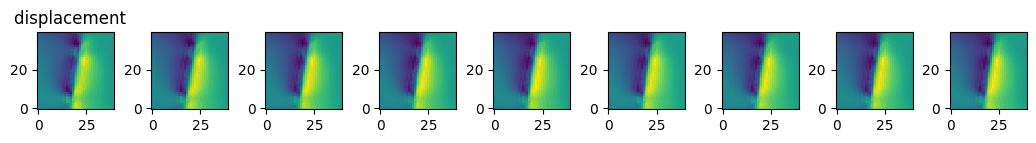

In [19]:
fig, (s0,s1,s2,s3,s4,s5,s6,s7,s8) = plt.subplots(1, 9, figsize = (13,1))
i=3
s0.title.set_text('displacement  ')
s0.imshow(VlosUltimate[i][0], interpolation="nearest")
s0.invert_yaxis()
s1.imshow(VlosUltimate[i][1].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s1.invert_yaxis()
s2.imshow(VlosUltimate[i][2].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s2.invert_yaxis()
s3.imshow(VlosUltimate[i][3].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s3.invert_yaxis()
s4.imshow(VlosUltimate[i][4].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s4.invert_yaxis()
s5.imshow(VlosUltimate[i][5].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s5.invert_yaxis()
s6.imshow(VlosUltimate[i][6].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s6.invert_yaxis()
s7.imshow(VlosUltimate[i][7].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s7.invert_yaxis()
s8.imshow(VlosUltimate[i][8].reshape(Egrid.shape, order = "F"), interpolation="nearest")
s8.invert_yaxis()

plt.show()



### displacement + noise

In [20]:
new_data = np.zeros((5,9,40,40))
for i in range(45):
    new_data[i//9][i - (i//9) * 9] = np.array(trbc_list[i]) + np.array(VlosUltimate[i//9][i - (i//9) * 9])

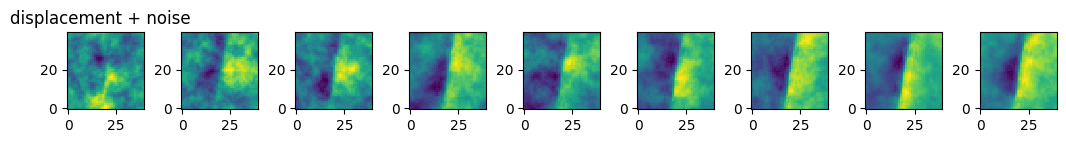

In [21]:
fig, (s0,s1,s2,s3,s4,s5,s6,s7,s8) = plt.subplots(1, 9, figsize = (13,1))
i=4
s0.title.set_text('displacement + noise  ')
s0.imshow(new_data[i][0], interpolation="nearest")
s0.invert_yaxis()
s1.imshow(new_data[i][1], interpolation="nearest")
s1.invert_yaxis()
s2.imshow(new_data[i][2], interpolation="nearest")
s2.invert_yaxis()
s3.imshow(new_data[i][3], interpolation="nearest")
s3.invert_yaxis()
s4.imshow(new_data[i][4], interpolation="nearest")
s4.invert_yaxis()
s5.imshow(new_data[i][5], interpolation="nearest")
s5.invert_yaxis()
s6.imshow(new_data[i][6], interpolation="nearest")
s6.invert_yaxis()
s7.imshow(new_data[i][7], interpolation="nearest")
s7.invert_yaxis()
s8.imshow(new_data[i][8], interpolation="nearest")
s8.invert_yaxis()

plt.show()